#[E - 17] Segmentation

###이 작업은 LMS가 아닌 코랩에서 작성을 하였으므로 cityscapes.zip을 로컬로 다운 후 알집을 해제하여 구글 드라이브에 업로드하여 진행하였다.

In [1]:
#Colab에서 작업하기위한 구글드라이브 마운트
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. 라이브러리 불러오기

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

##2. 데이터 불러오기

In [9]:
data_path = '/content/drive/MyDrive/E-17/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [4]:
data_path_val = '/content/drive/MyDrive/E-17/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path_val)))

number of val examples : 5


- 임의의 학습용 데이터셋 6개 시각화

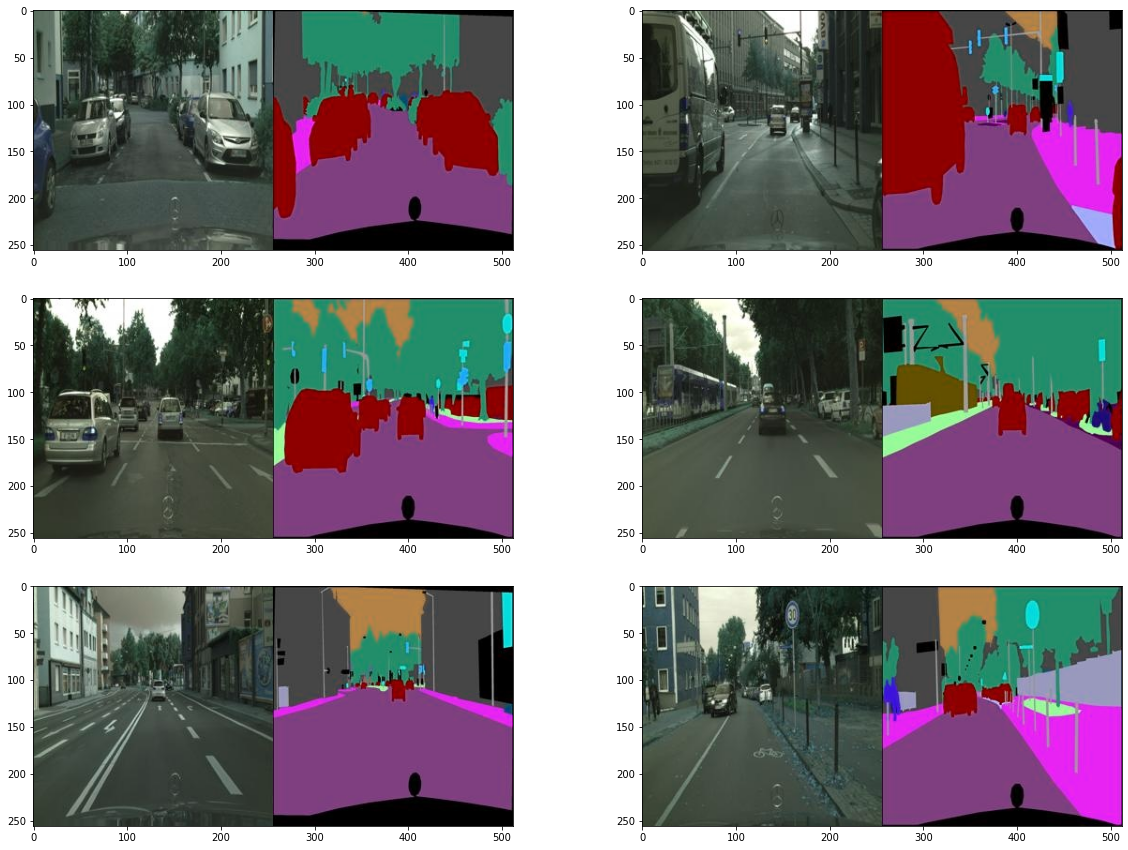

In [10]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이미지가 256x256 크기 2개로 이어져 256x512형태이다.

In [11]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 두 개의 이미지로 나누기

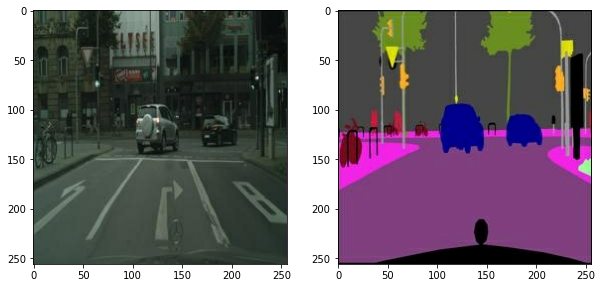

In [12]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- augmentation 적용(이미지 crop, flip, rotate)

In [15]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


- 이미지 시각화

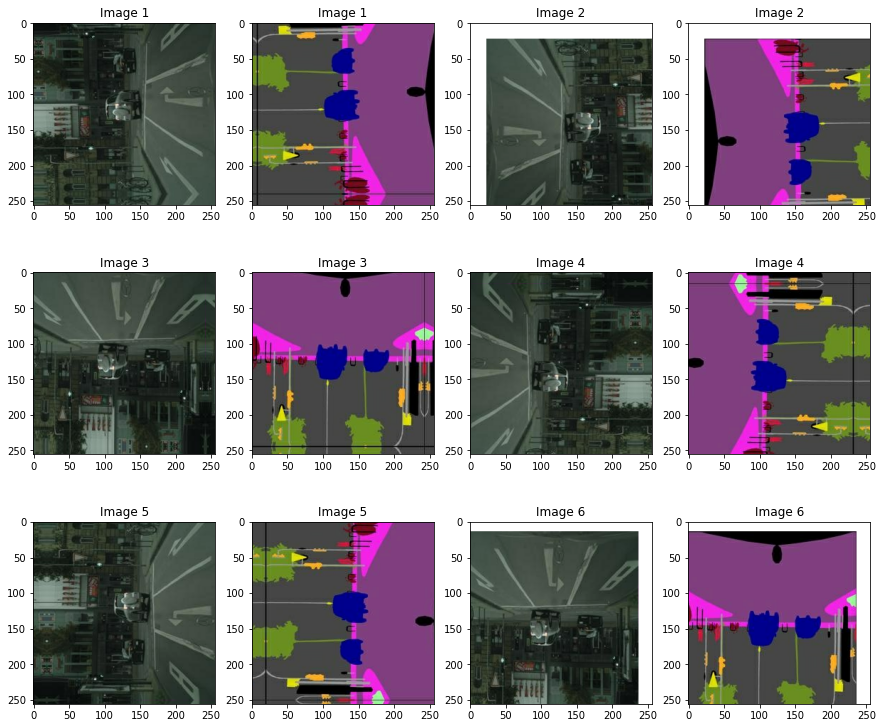

In [16]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 위 과정이 잘 적용되었는지 1개의 이미지 시각화

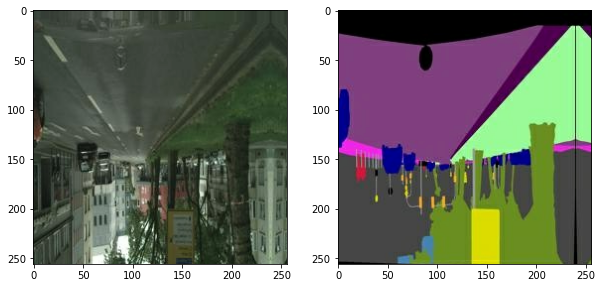

In [17]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

##3. Generator

In [19]:
from tensorflow.keras import layers, Input, Model
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [21]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [22]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

## 4. Discriminator

In [24]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [27]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()  

In [28]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

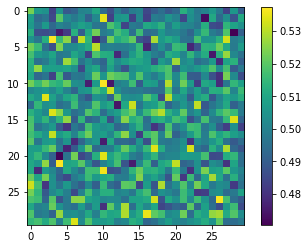

In [29]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

##5. 모델 학습 및 테스트

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [39]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [40]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8572                     
L1_loss:0.3621                     
Discriminator_loss:1.2559

EPOCH[1] - STEP[20]                     
Generator_loss:0.9862                     
L1_loss:0.3029                     
Discriminator_loss:1.1314

EPOCH[1] - STEP[30]                     
Generator_loss:0.9772                     
L1_loss:0.2731                     
Discriminator_loss:1.0736

EPOCH[1] - STEP[40]                     
Generator_loss:1.4199                     
L1_loss:0.2586                     
Discriminator_loss:0.7053

EPOCH[1] - STEP[50]                     
Generator_loss:1.6112                     
L1_loss:0.2618                     
Discriminator_loss:0.7421

EPOCH[1] - STEP[60]                     
Generator_loss:1.7494                     
L1_loss:0.2173                     
Discriminator_loss:0.6090

EPOCH[1] - STEP[70]                     
Generator_loss:1.3460                     
L1_loss:0.2914                    

- Epoch(10) 결과

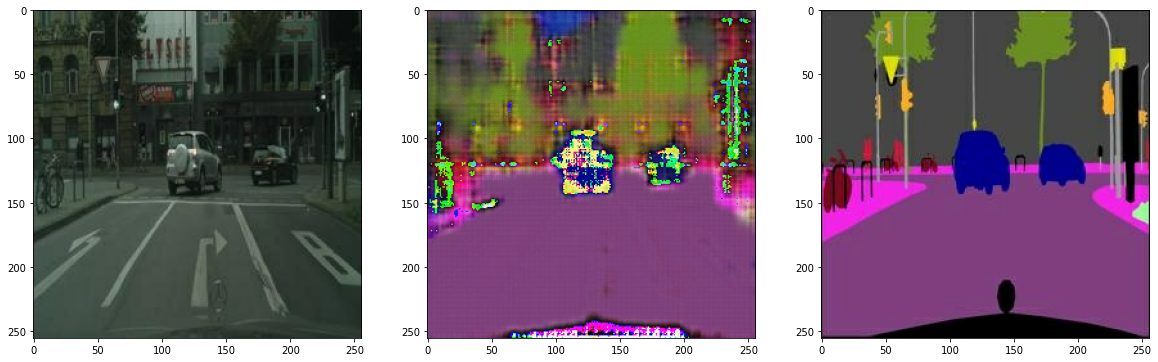

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))